In [1]:
import numpy as np
import os
import glob as glob
import SimpleITK as sitk
from tqdm import tqdm
import cv2
from datetime import datetime
import json
from scipy.interpolate import interp1d
from fpdf import FPDF
from metrics import *
import pydicom
from scipy import ndimage
import pickle 
import time
from skimage.morphology import skeletonize
import matplotlib
#matplotlib.use('AGG')
import matplotlib.pyplot as plt
from scipy.io import savemat
from skimage import measure, feature, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import imutils
from PIL import Image
from scipy.signal import savgol_filter, argrelextrema
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import copy
from math import log10, floor
import math
from skan import Skeleton, summarize
import IPython.display as Disp
from ipywidgets import widgets 

import teeth_prediction as ts
import canal_segmentation as cs

#from rendering import main_3DRendering
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

#import GPUtil
#from numba import cuda

2022-05-23 10:35:32.523818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
class Mandibular_Canal():
    def __init__(self):
        self.pix_x = 'no scan loaded yet'
        self.pix_y = 'no scan loaded yet'
        self.pix_z = 'no scan loaded yet'
        
        self.scan = 'no scan loaded yet'
        self.canal_mask = 'no scan loaded yet'
        self.teeth_mask = 'no scan loaded yet'
        
        self.panorama_view = 0
        self.panorama_view_mask = 0
        
        self.parasagittal_view = []
        
        self.frontal_view = 0
        self.sideMIP_left = 0
        self.sideMIP_right = 0
        self.minimum_distances = 0
        self.minimum_distance = 0
        self.axial_view = 0
        self.axial_perpendicular = 0
        
        self.parsagittal_radius = 50
        self.parsagittal_skips=2
        self.parsagittal_starting= 30 #(i)
        self.parsagittal_count=10
        self.parsagittal_gr_skips=40
        self.parasagittal_arch = 0
        self.parasagittal_windowed_scan = 0
        self.parasagittal_runtimes = 3
        
        self.panorama_arch = 0
        self.panorama_ss = 35
        self.panorama_length = 30 
        self.panorama_cond = False
        self.panorama_skips = 20
        self.panorama_windowed_scan = 0
        
        self.uid = 0
        self.output_list=[]
        self.classUID=[]
        self.mimeType = []
        self.annotations=[]
        self.recommendation_string = []
        
        self.gpu_id= 1
        #self.gpu_state = self.gpu_status()
        
    def get_full_scan(self,folder_path):

        files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
        itkimage = sitk.ReadImage(files_List[0])
        rows = int(itkimage.GetMetaData('0028|0010'))
        cols = int(itkimage.GetMetaData('0028|0011'))
        
        pix = (itkimage.GetMetaData('0028|0030'))
        self.pix_x = float(pix.split('\\')[-1])
        self.pix_y = float(pix.split('\\')[0])
        self.pix_z = float(itkimage.GetMetaData('0018|0050'))
        
        mn = 1000
        mx = 0
        for file in tqdm(files_List):
            itkimage = sitk.ReadImage(file)
            mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
            mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
        full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
        siuid = np.ndarray(shape=(mx-mn+1), dtype=object)   #, order='F')
        for file in tqdm(files_List):
            img, n,s = self.dcm_image(file)
            n = int(n)
            full_scan[n-mn,:,:] = img[0,:,:]
            siuid[n-mn] = s
            
        self.scan = full_scan
        self.uid = siuid

    def dcm_image(self,filename):
        itkimage = sitk.ReadImage(filename)
        numpyImage = sitk.GetArrayFromImage(itkimage)
        ins = float(itkimage.GetMetaData('0020|0013'))
        siuid = str(itkimage.GetMetaData('0008|0018'))
        return numpyImage, ins,siuid


    def get_normalized(self,scan,mn,mx):
        scann = copy.copy(scan)
        mn = max(mn,np.amin(scann))
        mx = min(mx,np.amax(scann))
        np.clip(scann, mn, mx, out=scann)
        d = mx - mn
        scann = (scann-mn)/d
        return scann



    def mask_to_polygons_layer(self,mask):
        most_polygons = []
        for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
            shh = shape['coordinates']
            for k in range(len(shh)):
                sh = shh[k]
                sh = np.squeeze(sh)
                sh = np.asarray(sh)
                sh = sh.flatten()
                #sh = sh.astype(np.uint16)
                sh = list(sh)
                most_polygons.append(sh)
        return most_polygons



    def get_normalized_image(self,img):
        mini = img.min()
        maxi = img.max()
        if not maxi==mini:
            d = maxi - mini
            img = ((img-mini)/d)*255
        return img



    def plot_3d(self,image, threshold=100, alpha=0.5):

        # Position the scan upright, 
        # so the head of the patient would be at the top facing the camera
        p = image.transpose(2,1,0)
        p = p[:,:,::-1]

        verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)

        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces], alpha=alpha)
        face_color = [0.8, 0.2, 1]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])

        plt.show()

    def get_Filename(self,file):
        file = file.split('/')[-1]
        file = file.split('.')[0]
        return file


    def normalize_3D_mask(self,scan):
        nscan = np.zeros((512, 512, scan.shape[2]), 'uint8')
        for i in tqdm(range(scan.shape[2])):
            s = scan[:,:,i]
            s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_NEAREST)
            nscan[:,:,i] = s
        nnscan = np.zeros((512, 512, 512), 'uint8')

        for i in range(512):
            s = nscan[i,:,:]
            s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_NEAREST)
            nnscan[i,:,:] = s

        return nnscan    



    def normalize_3D_scan(self,scan):
        nscan = np.zeros((512, 512, scan.shape[2]), 'uint8')
        for i in tqdm(range(scan.shape[2])):
            s = scan[:,:,i]
            s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
            nscan[:,:,i] = s
        nnscan = np.zeros((512, 512, 512), 'uint8')

        for i in range(512):
            s = nscan[i,:,:]
            s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
            nnscan[i,:,:] = s

        return nnscan


    def res_scan(self,nscan):
        desired_depth = 512
        desired_width = 512
        desired_height = 512
        current_depth = nscan.shape[0]
        current_width = nscan.shape[2]
        current_height = nscan.shape[1]
        depth_factor = desired_depth/current_depth
        width_factor = desired_width/current_width
        height_factor = desired_height/current_height
        nscann = copy.copy(nscan)
        nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
        return nscann

    def res_mask(self,nmask):
        desired_depth = 512
        desired_width = 512
        desired_height = 512
        current_depth = nmask.shape[0]
        current_width = nmask.shape[2]
        current_height = nmask.shape[1]
        depth_factor = desired_depth/current_depth
        width_factor = desired_width/current_width
        height_factor = desired_height/current_height
        nmaskk = copy.copy(nmask)
        nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
        return nmaskk


    def readJsonLeft(self,file,sz):

        mask = np.zeros(sz)
        mask = mask.astype('uint8')

        with open(file) as json_file:
            data = json.load(json_file)   

        left_coords = data['annotation']['tooth']['Left']['coordinate']

        l = int(len(left_coords)/3)
        b = {}
        b[0] = np.zeros((l, 1))
        b[1] = np.zeros((l, 1))
        b[2] = np.zeros((l, 1))
        j = 0
        for x in range(0, len(left_coords), 3):
            b[0][j] = int(left_coords[x])
            b[1][j] = int(left_coords[x+1])
            b[2][j] = int(left_coords[x+2])
            j = j + 1

        for i in range(len(b[0])):
            mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

        return mask

    def readJsonRight(self,file,sz):

        mask = np.zeros(sz)
        mask = mask.astype('uint8')

        with open(file) as json_file:
            data = json.load(json_file)   

        left_coords = data['annotation']['tooth']['Right']['coordinate']

        l = int(len(left_coords)/3)
        b = {}
        b[0] = np.zeros((l, 1))
        b[1] = np.zeros((l, 1))
        b[2] = np.zeros((l, 1))
        j = 0
        for x in range(0, len(left_coords), 3):
            b[0][j] = int(left_coords[x])
            b[1][j] = int(left_coords[x+1])
            b[2][j] = int(left_coords[x+2])
            j = j + 1

        for i in range(len(b[0])):
            mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

        return mask



    

    def offset(self,coordinates, distance):
        #coordinates = iter(coordinates)
        x1, y1 = coordinates[0]
        z = distance
        points = []
        for x2, y2 in coordinates:
            # tangential slope approximation
            try:
                slope = (y2 - y1) / (x2 - x1)
                # perpendicular slope
                pslope = -1/slope  # (might be 1/slope depending on direction of travel)
            except ZeroDivisionError:
                continue
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2

            sign = ((pslope > 0) == (x1 > x2)) * 2 - 1

            # if z is the distance to your parallel curve,
            # then your delta-x and delta-y calculations are:
            #   z**2 = x**2 + y**2
            #   y = pslope * x
            #   z**2 = x**2 + (pslope * x)**2
            #   z**2 = x**2 + pslope**2 * x**2
            #   z**2 = (1 + pslope**2) * x**2
            #   z**2 / (1 + pslope**2) = x**2
            #   z / (1 + pslope**2)**0.5 = x

            delta_x = sign * z / ((1 + pslope**2)**0.5)
            delta_y = pslope * delta_x

            points.append((mid_x + delta_x, mid_y + delta_y))
            x1, y1 = x2, y2
        return points

    def remove_isolated_pixels(self,image):
        connectivity = 16
        image = np.where(image>0,255,0)
        image = image.astype(np.uint8)
        output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

        num_stats = output[0]
        labels = output[1]
        stats = output[2]

        new_image = image.copy()

        for label in range(num_stats):
            if stats[label,cv2.CC_STAT_AREA] == 1:
                new_image[labels == label] = 0

        return new_image

    def remove_sk_branches(self,sk):
        branch_data = summarize(Skeleton(sk))
        #branch_data
        columns = []
        if not len(branch_data) < 2:
            for i in range(len(branch_data['skeleton-id'])):
                if not branch_data['branch-type'][i]==2:
                    jun = col2 = branch_data['image-coord-src-1'][i]
                    jun2 = row2 =  branch_data['image-coord-src-0'][i]
                    dist = branch_data['branch-distance'][i]
                    col = branch_data['image-coord-dst-1'][i]
                    row = branch_data['image-coord-dst-0'][i]
                    found = False
                    for x in columns:
                        if ((x[0]==jun2) and (x[1]==jun)) or ((x[0]==row) and (x[1]==col)) or ((x[2]==jun2) and (x[3]==jun)) or ((x[2]==row) and (x[3]==col)): 
                        #if (np.any(x)==jun) or (np.any(x)==jun2):
                            found = True
                            ind1 = columns.index(x)
                            columns[ind1].append([dist,row,col,row2,col2])
                            break
                    if found==False:
                        columns.append([jun2,jun,row,col])
                        ind1 = columns.index([jun2,jun,row,col])
                        columns[ind1].append([dist,row,col,row2,col2])

        remove = []
        if not len(branch_data) < 2:
            for jun in columns:
                if len(jun)>5:
                    common1 = jun[4][1]
                    common2 = jun[4][2]
                    if not ((jun[5][1]==common1) or (jun[5][3]==common1)):
                        common1 = jun[4][3]
                        common2 = jun[4][4]
                    mini = 100000
                    for i in range(4,len(jun),1):
                        mini = min(mini,jun[i][0])
                    for x in range(4,len(jun),1):
                        if mini in jun[x]:
                            break
                    if not ((jun[x][1]==common1) and (jun[x][2]==common2)):
                        remove.append([jun[x][1],jun[x][2],jun[x][3],jun[x][4]])
                    else:
                        remove.append([jun[x][3],jun[x][4],jun[x][1],jun[x][2]])

        if not len(branch_data) < 2:
            for i in range(len(branch_data['skeleton-id'])):
                if not branch_data['branch-type'][i]==2:
                    dist = branch_data['branch-distance'][i]
                    if dist < 20:
                        jun = col2 = branch_data['image-coord-src-1'][i]
                        jun2 = row2 =  branch_data['image-coord-src-0'][i]
                        col = branch_data['image-coord-dst-1'][i]
                        row = branch_data['image-coord-dst-0'][i]
                        if not (([row,col,row2,col2] in remove) or ([row2,col2,row,col] in remove)):
                            remove.append([row,col,row2,col2])
                        break

        if not remove==[]:
            for p in remove:
                x=True
                s0 = int(p[0])
                s1 = int(p[1])
                e0 = int(p[2])
                e1 = int(p[3])
                cond = True
                jab = True
                while(x == True):
                    if (jab==True)and(cond==True):
                        sk[s0,s1]=False
                        cond = False
                        for i in range(-1,2,1):
                            for j in range(-1,2,1):
                                if (sk[s0+i , s1+j]>0):
                                    if not ((s0+i >= e0-1)and(s0+i <= e0+1)and(s1+j >= e1-1)and(s1+j <= e1+1)):
                                        s0 = s0+i
                                        s1 = s1+j
                                        cond = True
                                        break
                                    else:
                                        jab=False
                                        cond = True
                                        break
                            if cond==True:
                                break
                    else:
                        break
            sk = self.remove_sk_branches(sk)
            return sk
        else:
            sk = self.remove_isolated_pixels(sk)
            return sk


    def min_dist(self,res0,maskt,maskc):
        from scipy.spatial import distance
        res0[:,:,0] = np.where(maskt>0,0,res0[:,:,0])
        res0[:,:,1] = np.where(maskt>0,0,res0[:,:,1])
        res0[:,:,2] = np.where(maskt>0,255,res0[:,:,2])
        res0[:,:,0] = np.where(maskc>0,255,res0[:,:,0])
        res0[:,:,1] = np.where(maskc>0,0,res0[:,:,1])
        res0[:,:,2] = np.where(maskc>0,0,res0[:,:,2])
        teethpoint = np.argwhere((res0[:,:,0]==0)&(res0[:,:,1]==0)&(res0[:,:,2]==255))
        canalpoint = np.argwhere((res0[:,:,0]==255)&(res0[:,:,1]==0)&(res0[:,:,2]==0))
        teethpoint = teethpoint[teethpoint[:,0].argsort()]
        canalpoint = canalpoint[canalpoint[:,0].argsort()]
        distances = distance.cdist(teethpoint,canalpoint)
        if len(distances)>1:
            [teethp,canalp] = np.squeeze(np.where(distances == np.min(distances)))
            if isinstance(teethp, np.ndarray): 
                teethp = teethp[-1]
            if isinstance(canalp, np.ndarray): 
                canalp = canalp[-1]
            [ty,tx] = teethpoint[teethp]
            [cy,cx] = canalpoint[canalp]
            dist = math.sqrt(((ty-cy)**2)+((tx-cx)**2))
            dist = dist*0.2
            newpara = cv2.arrowedLine(res0, (cx,cy), (tx,ty),(210,150,210),1)
        else:
            dist = 'none'
            newpara = res0
        return dist,newpara


    def crop_sag(self,img):
        crop = self.parasaggital_radius
        
        imgg=np.zeros((img.shape[0],img.shape[1]))
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i,j,0] == 255 and img[i,j,1]==0 and img[i,j,2]==0:
                    imgg[i,j]=1
        if np.any(imgg):
            area = 0
            contours,_=cv2.findContours(imgg.astype(np.uint8), cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
            for contour in contours:
                area1 = cv2.contourArea(contour)
                if area1>area:
                    cnt = contour
                    area = area1
            try:
                M = cv2.moments(cnt)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
            except:
                cx = contour[0][0][0]
                cy = contour[0][0][1]

            if cx-crop<0:
                cx1 = 0
            else:
                cx1 = cx-crop
            if cx+crop>img.shape[1]:
                cx2 = img.shape[1]
            else:
                cx2 = cx+crop
            if cy+crop > img.shape[0]:
                cy2 = img.shape[0]
                cy1 = cy2-(2*crop)
            else:
                cy1 = cy-crop
                cy2 = cy+crop
            cropped = img[cy1:cy2,cx1:cx2,:]


            maskt = np.where((cropped[:,:,0]==0)&(cropped[:,:,1]==0)&(cropped[:,:,2]==255),255,0)
            maskc = np.where((cropped[:,:,0]==255)&(cropped[:,:,1]==0)&(cropped[:,:,2]==0),255,0)

            cropped = self.set_scale(cropped,'front')

            maskt = cv2.resize(maskt.astype(np.uint8), (cropped.shape[1],cropped.shape[0]), interpolation=cv2.INTER_NEAREST)
            maskc = cv2.resize(maskc.astype(np.uint8), (cropped.shape[1],cropped.shape[0]), interpolation=cv2.INTER_NEAREST)

            dist,cropped = self.min_dist(cropped,maskt,maskc)

            if dist=='none':
                text = dist
                dist = 10000
            else:
                text = str(round(dist,2))+'mm'
            position = (cropped.shape[1]-60,10)
            font = 0.4
            cropped = cv2.putText(cropped,text,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255,255,255)) 

            return dist, cropped
        else:
            img = np.zeros((crop,crop))
            dist = 10000
            return dist, img

    def get_parasagittal(self,starting):
        
        scan = copy.copy(self.scan)
        ysize = int(scan.shape[0]/2)
        xsize = int(scan.shape[1]/2)
        view = np.zeros((scan.shape[0],scan.shape[1]))
        perp_scan = []
        perpi_coords=[]
        perp_without = []
        z=0
        lll = 0 
        flag = False 
        nextiter = round((starting+(self.parsagittal_skips*self.parsagittal_count)))
        for i in range(self.parsagittal_skips,self.parsagittal_coords.shape[0],self.parsagittal_skips):
            if (z>=starting) and (z<nextiter):
                x1 = self.parsagittal_coords[i-self.parsagittal_skips,1]
                y1 = self.parsagittal_coords[i-self.parsagittal_skips,0]

                if i+self.parsagittal_gr_skips-1 < self.parsagittal_coords.shape[0]:
                    x2 = self.parsagittal_coords[i-self.parsagittal_skips+self.parsagittal_gr_skips-1,1]
                    y2 = self.parsagittal_coords[i-self.parsagittal_skips+self.parsagittal_gr_skips-1,0]
                else:
                    x2 = self.parsagittal_coords[-1,1]
                    y2 = self.parsagittal_coords[-1,0]

                #x2 = coords[i,1]
                #y2 = coords[i,0]
                x1 = x1-xsize
                y1 = ysize-y1
                x2 = x2-xsize
                y2 = ysize-y2
                m = (y2-y1)/(x2-x1)
                #y_bi = round((y2+y1)/2)
                #x_bi = round((x2+x1)/2)
                y_bi = y1
                x_bi = x1
                if not m==0:
                    m_p = -1/m  
                    intercept = (y_bi - (m_p*x_bi))
                    #perp_coords = np.zeros((0,2),dtype = 'int')
                    #if abs(m_p)<=1:
                    py1 = round(m_p*(-xsize) + intercept)
                    if (py1>-ysize) and (py1<=ysize):
                        px1 = round(-xsize)
                    elif py1 <= -ysize:
                        py1 = round(-ysize+1)
                        px1 = round(py1 - intercept)/m_p
                    else:
                        py1 = round(ysize)
                        px1 = round(py1 - intercept)/m_p
                    py2 = round(m_p*(xsize-1) + intercept)
                    if (py2>-ysize) and (py2<=ysize):
                        px2 = round(xsize-1)
                    elif py2 <= -ysize:
                        py2 = round(-ysize+1)
                        px2 = round(py2 - intercept)/m_p
                    else:
                        py2 = round(ysize)
                        px2 = round(py2 - intercept)/m_p
                    px1 = round(px1+xsize)
                    px2 = round(px2+xsize)
                    py1 = round(ysize-py1)
                    py2 = round(ysize-py2)
                    x_bi = round(x_bi+xsize)
                    y_bi = round(ysize-y_bi)
                    xarray = np.array([px1,px2])
                    yarray = np.array([py1,py2])

                    if abs(m_p)<=1:
                        x_new = np.linspace(xarray.min(), xarray.max(),(xarray.max()-xarray.min()+1)).astype(np.uint)
                        f = interp1d(xarray, yarray, kind='linear')
                        y_smooth=f(x_new)
                    else:
                        y_smooth = np.linspace(yarray.min() ,yarray.max(), (yarray.max()-yarray.min()+1)).astype(np.uint)
                        f = interp1d(yarray, xarray, kind='linear')
                        x_new = f(y_smooth)
                    y_smooth = y_smooth.astype(np.uint)
                    x_new = x_new.astype(np.uint)
                    newarray = np.zeros_like(view)
                    newarray[y_smooth,x_new] = 255
                    points = np.argwhere(newarray>0)
                    ind = np.lexsort((points[:,0], points[:,1])) 
                    points = points[ind]
                    point = np.abs(points[:,1]-x_bi).argmin()
                    hypo = 200
                    B = hypo*(math.sin(m_p))
                    A = hypo*(math.cos(m_p))
                    px1 = x_bi-(A/2)
                    px2 = x_bi+(A/2)
                    py1 = y_bi+(B/2)
                    py2 = y_bi-(B/2)
                    p1 = min(np.abs(points[:,1]-px1).argmin() , np.abs(points[:,0]-py1).argmin())
                    p2 = max(np.abs(points[:,1]-px2).argmin() , np.abs(points[:,0]-py2).argmin())
                    #point = np.argwhere(points[:,1]==x_bi)
                    #point = point.min() + np.abs(points[int(point.min()):int(point.max()),0]-y_bi).argmin()
                    perp_coords = points[round(p1):round(p2),:]


                else:
                    perp_coords = np.zeros((140,2),dtype = int) #140
                    perp_coords[:,1] = round(x_bi+xsize)
                    if ysize-y_bi-70 <=0:
                        array = np.arange(0,140).astype(np.uint16)
                        array = np.flip(array)
                        perp_coords[:,0] = array
                    else:
                        array = np.arange((ysize-y_bi)-70,(ysize-y_bi)+70).astype(np.uint16) ##20  120
                        array = np.flip(array)
                        perp_coords[:,0] = array
                perpi_coords.append(perp_coords)
                perp = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
                perp_m = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
                perp_tm = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
                for x in range(perp_coords.shape[0]):
                    perp[:,x] = scan[:,perp_coords[x,0],perp_coords[x,1]]
                    perp_m[:,x] = self.canal_mask[:,perp_coords[x,0],perp_coords[x,1]].astype(np.uint16)
                    perp_tm[:,x] = self.teeth_mask[:,perp_coords[x,0],perp_coords[x,1]].astype(np.uint16)
                    view[perp_coords[x,0],perp_coords[x,1]]=255

                perp_tm = perp_tm.astype(np.uint8)
                contours,_ = cv2.findContours(perp_tm,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                perp_tm = np.zeros_like(perp_tm)
                perp_tm = cv2.drawContours(perp_tm, contours, -1, (1), 1)

                ##Draw outline
                perp_m = perp_m.astype(np.uint8)
                contours,_ = cv2.findContours(perp_m,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                perp_m = np.zeros_like(perp_m)
                perp_m = cv2.drawContours(perp_m, contours, -1, (1), 1)

                ##Draw point
                #perp_m = perp_m.astype(np.uint8)
                #contours,_ = cv2.findContours(perp_m,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                #perp_m = np.zeros_like(perp_m)
                for cnt in contours:
                    try:
                        M = cv2.moments(cnt)
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                        perp_m = cv2.circle(perp_m, (cx,cy), 1, 1, -1)
                    except:
                        continue


                perp_3d = np.zeros((perp.shape[0],perp.shape[1],3),int)
                perp_3d[:,:,0] = np.where(perp_m==1,255,perp)
                perp_3d[:,:,1] = np.where(perp_m==1,0,perp)
                perp_3d[:,:,2] = np.where(perp_m==1,0,perp)

                perp_3d[:,:,0] = np.where(perp_tm==1,0,perp_3d[:,:,0])
                perp_3d[:,:,1] = np.where(perp_tm==1,0,perp_3d[:,:,1])
                perp_3d[:,:,2] = np.where(perp_tm==1,255,perp_3d[:,:,2])
                #perp_m_i = 1-perp_m
                #perp_3d[:,:,0]=perp[:,:]*perp_m_i[:,:] + perp_m[:,:]*255
                #perp_3d[:,:,1]=perp[:,:]*perp_m_i[:,:]
                #perp_3d[:,:,2]=perp[:,:]*perp_m_i[:,:]
                perp_scan.append(perp_3d)
                perp_without.append(perp)
                lll = lll+1
            z= z + self.parsagittal_skips

        return perp_scan,perp_without,view


    def get_panoramic(self):
        
        scan = copy.copy(self.scan)
        view = np.zeros((self.panorama_arch.shape[0],self.panorama_arch.shape[1]))
        view_without = np.zeros((self.panorama_arch.shape[0],self.panorama_arch.shape[1]))
        xsize = round(self.panorama_arch.shape[1]/2)
        ysize = round(self.panorama_arch.shape[0]/2)
        without_scan = np.zeros((scan.shape[0],0))
        pano_mask = np.zeros((scan.shape[0],0),int)
        para_coords = []
        for i in range(0,self.panorama_coords.shape[0]-1,1):
            #teeth_flag = False
            x1 = self.panorama_coords[i,1]
            y1 = self.panorama_coords[i,0]
            if i+self.panorama_skips-1 < self.panorama_coords.shape[0]:
                x2 = self.panorama_coords[i+self.panorama_skips-1,1]
                y2 = self.panorama_coords[i+self.panorama_skips-1,0]
            else:
                x2 = self.panorama_coords[-1,1]
                y2 = self.panorama_coords[-1,0]
            x1 = x1-xsize
            y1 = ysize-y1
            x2 = x2-xsize
            y2 = ysize-y2
            m = (y2-y1)/(x2-x1)
            y_bi = y1
            x_bi = x1
            #if np.any(teeth_ax[:,x_bi+xsize])>0:
            #    teeth_flag = True
            if (not m==0):
                m_p = -1/m  
                intercept = (y_bi - (m_p*x_bi))
                perp_coords = np.zeros((0,2),dtype = 'int')
                #teeth=np.zeros((0,2),dtype = 'int')
                without = np.zeros((0,2),dtype = 'int')
                if abs(m_p)<=1:
                    for x in range(x_bi-self.panorama_ss,x_bi+self.panorama_ss):
                        y = round(m_p*x + intercept)
                        xx = round(x+xsize)
                        yy= round(ysize-y)
                        if yy>=scan.shape[1] or yy<0 or xx>=scan.shape[1] or xx<0:
                            continue
                        else:
                            perp_coords = np.vstack((perp_coords,[yy,xx]))
                            #if x<=x_bi+10 and x>=xx_bi+10:
                            #    teeth = np.vstack((teeth,[yy,xx]))
                            if x<=x_bi+self.panorama_length and x>=x_bi-self.panorama_length:
                                without = np.vstack((without,[yy,xx]))
                else:
                    for y in range(y_bi-self.panorama_ss,y_bi+self.panorama_ss):
                        x = round((y-intercept)/m_p)
                        xx = round(x+xsize)
                        yy= round(ysize-y)
                        if yy>=scan.shape[1] or yy<0 or xx>=scan.shape[1] or xx<0:
                            continue
                        else:
                            perp_coords = np.vstack((perp_coords,[yy,xx]))
                            #if x<=x_bi+10 and x>=xx_bi+10:
                            #    teeth = np.vstack((teeth,[yy,xx]))
                            if y<=y_bi+self.panorama_length and y>=y_bi-self.panorama_length:
                                without = np.vstack((without,[yy,xx]))


            else:
                if self.panorama_cond==True:
                    perp_coords = np.zeros((int(self.panorama_ss*3),2),dtype = int)
                    without = np.zeros((int(self.panorama_length*3),2),dtype = int)
                    perp_coords[:,1] = round(x_bi+xsize)
                    without[:,1] = round(x_bi+xsize)
                    if (ysize-y_bi-(2*self.panorama_ss))<0:
                        ran1 = 0
                        ran2 = int(3*self.panorama_ss)
                        perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                    else:
                        ran1 = int(ysize-y_bi-(2*self.panorama_ss))
                        ran2 = int(ysize-y_bi+self.panorama_ss)
                        perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                    if (ysize-y_bi-(2*self.panorama_length))<0:
                        ran_1 = 0
                        ran_2 = int(3*self.panorama_length)
                    else:
                        ran_1 = int(ysize-y_bi-(2*self.panorama_length))
                        ran_2 = int(ysize-y_bi+self.panorama_length)
                else:
                    lolo = False
                    perp_coords = np.zeros((int(self.panorama_ss*2),2),dtype = int)
                    #perp_coords = np.zeros((int(ss*3),2),dtype = int)
                    without = np.zeros((int(self.panorama_length*2),2),dtype = int)
                    perp_coords[:,1] = round(x_bi+xsize)
                    #perp_coords[:,1] = round(x_bi+xsize)
                    without[:,1] = round(x_bi+xsize)
                    if (ysize-y_bi-(self.panorama_ss))<0:
                        ran1 = 0
                        ran2 = int(2*self.panorama_ss)
                        perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                    else:
                        ran1 = int(ysize-y_bi-(self.panorama_ss))
                        ran2 = int(ysize-y_bi+self.panorama_ss)
                        perp_coords[:,0] = np.arange(ran1,ran2).astype(np.uint16)
                    if (ysize-y_bi-(self.panorama_length))<0:
                        ran_1 = 0
                        ran_2 = int(2*self.panorama_length)
                        without[:,0] = np.arange(ran_1,ran_2).astype(np.uint16)
                    else:
                        ran_1 = int(ysize-y_bi-(self.panorama_length))
                        ran_2 = int(ysize-y_bi+self.panorama_length)
                        array =  np.arange(ran_1,ran_2).astype(np.uint16)
                        without[:,0] = array
            #perp = np.zeros((scan.shape[0],perp_coords.shape[0]))
            para_coords.append([perp_coords])
            perp_without = np.zeros((scan.shape[0],without.shape[0]))
            perp_m = np.zeros((scan.shape[0],perp_coords.shape[0]),int)
            for x in range(perp_coords.shape[0]):
                #perp[:,x] = scan[:,perp_coords[x,0],perp_coords[x,1]]
                perp_m[:,x] = self.canal_mask[:,perp_coords[x,0],perp_coords[x,1]].astype(np.uint8)
                view[perp_coords[x,0],perp_coords[x,1]]=255
            for x in range(without.shape[0]):
                perp_without[:,x] = scan[:,without[x,0],without[x,1]]
                view_without[without[x,0],without[x,1]]=255
            #perp_mip = np.amax(perp,axis=1)
            without_mip = np.mean(perp_without,axis=1)
            perp_m_mip = np.amax(perp_m,axis=1)
            #pano_scan = np.column_stack((pano_scan,perp_mip))
            without_scan = np.column_stack((without_scan,without_mip))
            pano_mask = np.column_stack((pano_mask,perp_m_mip))
        without_scan = np.fliplr(without_scan)
        pano_mask = np.fliplr(pano_mask)
        pano_mask = pano_mask.astype(np.uint8)
        #ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)) 
        #pano_mask = ndimage.morphology.binary_closing(pano_mask,ker)
        pano_mask = pano_mask.astype(np.uint8)
        #pano_scan = pano_scan.astype(np.uint8)
        points = np.argwhere(pano_mask>0)
        start = int(np.amin(points[:,0]) -30)
        end = int(np.amax(points[:,0]) +30)
        pano_view=np.zeros((without_scan.shape[0],without_scan.shape[1],3),dtype = int)
        #pano_view[:,:,0] = np.where(pano_mask>0,255,without_scan)
        #pano_view[:,:,1] = np.where(pano_mask>0,0,without_scan)
        #pano_view[:,:,2] = np.where(pano_mask>0,0,without_scan)


        #plt.figure(figsize = (30,10))
        #plt.imshow(pano_view,'gray')
        #plt.imshow(pano_view,'gray')

        minimum = np.amin(without_scan)
        diff = np.amax(without_scan) - minimum
        without_scan = (without_scan-minimum)*255/diff
        without_scan = without_scan.astype(np.uint)
        con_ones_L = np.zeros_like(pano_mask)
        con_ones_R = np.zeros_like(pano_mask)
        con_zeros = 1 - pano_mask
        con_ones_L[:,int(pano_mask.shape[1]/2):] = pano_mask[:,int(pano_mask.shape[1]/2):]
        con_ones_R[:,:int(pano_mask.shape[1]/2)] = pano_mask[:,:int(pano_mask.shape[1]/2)]
        con_ones_L = np.where(con_ones_L>0,1,0)
        con_ones_R = np.where(con_ones_R>0,1,0)

        pano_view[:,:,0] = without_scan*con_zeros + con_ones_L*255
        pano_view[:,:,2] = without_scan*con_zeros + con_ones_R*255
        pano_view[:,:,1] = without_scan*con_zeros

        pano_view = pano_view[start:end,:]
        without_scan = without_scan[start:end,:]
        
        self.panorama = without_scan
        self.panorama_mask = pano_view
        
        return view_without,view,para_coords


    # In[12]:


    def dental_type2(self):
        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, -500, 4500)*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')  
        teeth_mask1 = np.amax(self.teeth_mask,axis = 1)
        teeth_mask1 = teeth_mask1>0
        teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
        teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=500)

        new_c = np.argwhere(teeth_mask1>0)
        start = np.amin(new_c[:,0])
        end = np.amax(new_c[:,0])
        cropped_scan = gscan[start:end,:,:]
        mask = copy.copy(self.canal_mask)
        mask = mask[start:end,:,:]
        #plt.figure(figsize = (10,10))
        d_mips = np.amax(cropped_scan,axis=0)
        #plt.imshow(teeth_mask1, 'gray')
        thres = d_mips>120 #100 
        thres = morphology.remove_small_objects(thres, min_size=200)
        thres = ndimage.morphology.binary_fill_holes(thres)
        #plt.imshow(thres,'gray')
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        #plt.imshow(thres,'gray')
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)

            if y<peri:
                peri = y
                index = num
            num = num+1

        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        points = np.argwhere(thres>0)
        row_cut1 = np.amin(points[:,0])
        row_cut2 = np.amax(points[:,0])
        col_cut1 = np.amin(points[:,1])
        col_cut2 = np.amax(points[:,1])
        s_mips = d_mips[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi-mini
        s_mips = (s_mips-mini)/d

        axial = s_mips*255
        #plt.figure(figsize = (10,10))
        #plt.imshow(d_mips,'gray')
        #plt.imshow(thres, 'gray')#,alpha=0.5)
        teethm = np.amax(self.teeth_mask,axis=0)
        teethm = teethm>0
        teethm = ndimage.morphology.binary_fill_holes(teethm)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teethm = ndimage.morphology.binary_closing(teethm,ker)#
        teethm = morphology.remove_small_objects(teethm, min_size=200)


        #plt.figure(figsize = (10,10))
        #plt.imshow(teethm,'gray')
        #thres = morphology.skeletonize(thres)
        teeth = copy.copy(teethm)
        teeth = skeletonize(teeth)
        #plt.figure(figsize = (10,10))
        #plt.imshow(teeth_sk,'gray')
        points = np.argwhere(teeth>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]

        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(teeth[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        #plt.plot(flattened)
        smoothed = savgol_filter(flattened.flatten(),95,3) #79
        archteeth = np.zeros_like(teeth)
        checkk = np.empty((0,2),dtype = int)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            checkk = np.vstack((checkk,[i,coord]))
            j=j+1

        points = np.argwhere(teethm>0)
        p1 = np.amin(points[:,0])
        p2 = np.amin(checkk[:,1])
        p = round((p2-p1)*1/2)
        parallel = self.offset(checkk, p)
        t = [x[0] for x in parallel]
        s = [x[1] for x in parallel]
        t = np.asarray(t)
        s = np.asarray(s)
        t = t[1:].astype(np.uint16)
        s = s[1:].astype(np.uint16)
        check = s
        check = np.column_stack((check,t))
        example = copy.copy(archteeth)
        #example[s,t] = 255
        x = np.empty((1,0))
        y = np.empty((1,0))
        for i in range(0,check.shape[0],3):
            if (not check[i,1]==0) and (not check[i,0]==0): 
                if i<check.shape[0]-3:
                    x = np.column_stack((x,check[i,1]))
                    y = np.column_stack((y,check[i,0]))
                else:
                    x = np.column_stack((x,check[-1,1]))
                    y = np.column_stack((y,check[-1,0]))
        xx = np.empty((1,0))
        yy = np.empty((1,0))
        j=0

        for i in range(0,len(x[0])-1):
            if not x[0,i]==x[0,i+1]:
                if x[0,i] > j:
                    xx = np.column_stack((xx,x[0,i]))
                    yy = np.column_stack((yy,y[0,i]))
                    j = xx.max()

        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten()

        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic') ###time 1
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        #example[y,x] = 255
        newy = np.gradient(y)
        j = np.argwhere((newy>=-0.5)&(newy<=0.5))

        j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)

        j = np.setdiff1d(j,np.asarray([-1]))

        j = j.reshape(-1,1)
        yy = np.empty((0,1))
        xx = np.empty((0,1))

        k = np.argwhere(checkk[:,0] < x[j[0]])
        k = k[-1]
        k = int(k)
        for i in range(0,k-20,5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        yy = np.vstack((yy,y[j]))
        xx = np.vstack((xx,x[j]))
        k = np.argwhere(checkk[:,0] > x[j[-1]])
        k = k[0]
        k = int(k)
        for i in range(k+20,checkk.shape[0],5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten()
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')###Time 2
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        example[y,x] = 255
        #plt.figure(figsize = (10,10))
        #plt.imshow(example,'gray')
        points = np.argwhere(example>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]

        #points = np.arwhere(teeth[:,:c1])
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(example[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))

        smoothed = savgol_filter(flattened.flatten(),115,3)


        archteeth = np.zeros_like(example)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            j=j+1

        #plt.figure(figsize = (10,10))
        #plt.imshow(d_mips,'gray')
        #plt.imshow(archteeth, 'gray',alpha=0.5)
        teeth = copy.copy(teethm)
        y = np.zeros((0,2),int)
        w1 = 1
        w2 = 10000
        for j in range(thres.shape[1]):
            num = 0
            den = 0
            for i in range(thres.shape[0]):
                if thres[i,j]==True:
                    if teeth[i,j]==True:
                        num = num + (i*w2)
                        den = den + w2
                    else:
                        num = num + (i*w1)
                        den = den + w1
            if not num==0:
                y = np.vstack((y,[round(num/den),j]))


        thresh=np.zeros_like(thres)
        for i in range(y.shape[0]):
            thresh[y[i,0],y[i,1]]=255

        #plt.figure(figsize = (10,10))
        #plt.imshow(d_mips,'gray')
        #plt.imshow(thresh, 'gray',alpha=0.5)
        flag = False
        for i in range(thresh.shape[0]):
            for j in range(thresh.shape[1]):
                if thresh[i,j]>0:
                    r1 = i
                    c1 = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(round((thresh.shape[1])/2)):
                if thresh[i,j]>0:
                    rl = i
                    cl = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
                if thresh[i,j]>0:
                    rr = i
                    cr = j
                    flag = True
                    break
            if flag==True:
                break

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))

        smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105  #35
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1
        #ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) 
        #thres = ndimage.morphology.binary_closing(thres,ker)


        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        points = np.argwhere(archteeth>0)
        p = np.argmin(points[:,1])
        [_,start] = teethstart =  points[p]
        p = np.argmax([points[:,1]])
        [_,end] = teethend = points[p]

        thresh = np.zeros_like(teeth)
        thresh[:,:start] = leftarch = arch[:,:start]
        thresh[:,start:end] = archteeth[:,start:end]
        thresh[:,end:] = rightarch =  arch[:,end:]

        points = np.argwhere(leftarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        p1 = points[0]
        step = int(len(points)/3)
        p2 = points[int(0.75*step)]
        p3 = points[int(2.5*step)]
        #p4 = points[int(2.7*step)]

        x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
        y = np.array([p1[0],p2[0],p3[0],teethstart[0]])

        x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothleft=f(x_newleft)
        points = np.argwhere(rightarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        points[:,1] = points[:,1]+end
        step = int(len(points)/3)
        #p1 = points[int(step*0.3)]
        p2 = points[int(0.5*step)]
        p3 = points[int(2.25*step)]
        p4 = points[-1]
        x = np.array([teethend[1],p2[1],p3[1],p4[1]])
        y = np.array([teethend[0],p2[0],p3[0],p4[0]])

        x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothright=f(x_newright)
        y = y_smoothleft.astype(np.uint)
        x = x_newleft.astype(np.uint)
        thresh = copy.copy(archteeth)
        thresh[y,x] = True
        y = y_smoothright.astype(np.uint)
        x = x_newright.astype(np.uint)
        thresh[y,x] = True
        points = np.argwhere(thresh>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        #plt.imsave("/home/rabeea/paper/final_initial.png",thresh,cmap = 'gray')
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),79,3) #109
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1

        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))


        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, 0, 4500)*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')  
        
        self.parasagittal_arch = arch
        self.parasagittal_coords = coords
        self.parasagittal_windowed_scan = gscan
        
        return d_mips,axial

    def dental_type1(self):
        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, 0, 2500)*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')
        teeth_mask1 = np.amax(self.teeth_mask,axis = 1)
        teeth_mask1 = teeth_mask1>0
        teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
        teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=200)
        new_c = np.argwhere(teeth_mask1>0)
        start = np.amin(new_c[:,0])
        end = np.amax(new_c[:,0])
        #start = int((start+end)/2)
        cropped_scan = gscan[start:end,:,:]
        #plt.figure(figsize = (10,10))
        d_mips = np.amax(cropped_scan,axis=0)
        #plt.imshow(d_mips, 'gray')
        thres = d_mips>70 
        thres = morphology.remove_small_objects(thres, min_size=500)
        thres = ndimage.morphology.binary_fill_holes(thres)
        #plt.imshow(thres,'gray')
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        #plt.imshow(thres,'gray')
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)

            if y<peri:
                peri = y
                index = num
            num = num+1

        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        points = np.argwhere(thres>0)
        row_cut1 = np.amin(points[:,0])
        row_cut2 = np.amax(points[:,0])
        col_cut1 = np.amin(points[:,1])
        col_cut2 = np.amax(points[:,1])

        teethm = np.amax(self.teeth_mask,axis=0)
        teethm = teethm>0
        teethm = ndimage.morphology.binary_fill_holes(teethm)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teethm = ndimage.morphology.binary_closing(teethm,ker)#
        teethm = morphology.remove_small_objects(teethm, min_size=200)
        alt_teeth = d_mips>115
        teethm = np.where(alt_teeth>0,1,teethm)
        teethm = teethm>0
        teethm = ndimage.morphology.binary_fill_holes(teethm)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)) 
        teethm = ndimage.morphology.binary_closing(teethm,ker)
        teethm = morphology.remove_small_objects(teethm, min_size=500)
        teethm = ndimage.morphology.binary_fill_holes(teethm)
        teeth = copy.copy(teethm)
        teeth = skeletonize(teeth)
        teeth = self.remove_sk_branches(teeth)

        points = np.argwhere(teeth>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        #points = np.arwhere(teeth[:,:c1])
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(teeth[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))

        smoothed = savgol_filter(flattened.flatten(),95,3)

        archteeth = np.zeros_like(teeth)
        checkk = np.empty((0,2),dtype = int)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            checkk = np.vstack((checkk,[i,coord]))
            j=j+1

        points = np.argwhere(teethm>0)
        p1 = np.amin(points[:,0])
        p2 = np.amin(checkk[:,1])
        p = round((p2-p1)/2)
        parallel = self.offset(checkk, p)
        t = [x[0] for x in parallel]
        s = [x[1] for x in parallel]
        t = np.asarray(t)
        s = np.asarray(s)
        t = t[1:].astype(np.uint16)
        s = s[1:].astype(np.uint16)
        check = s
        check = np.column_stack((check,t))
        example = archteeth
        #example[s,t] = 255
        x = np.empty((1,0))
        y = np.empty((1,0))
        for i in range(0,check.shape[0],3):
            if (not check[i,1]==0) and (not check[i,0]==0): 
                if i<check.shape[0]-3:
                    x = np.column_stack((x,check[i,1]))
                    y = np.column_stack((y,check[i,0]))
                else:
                    x = np.column_stack((x,check[-1,1]))
                    y = np.column_stack((y,check[-1,0]))

        xx = np.empty((1,0))
        yy = np.empty((1,0))
        j=0
        for i in range(len(x[0])-1):
            if not x[0,i]==x[0,i+1]:
                if x[0,i] > j:
                    xx = np.column_stack((xx,x[0,i]))
                    yy = np.column_stack((yy,y[0,i]))
                    j=xx.max()

        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten()
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        #example[y,x] = 255
        newy = np.gradient(y)
        j = np.argwhere((newy>=-0.5)&(newy<=0.5))

        j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)

        j = np.setdiff1d(j,np.asarray([-1]))

        j = j.reshape(-1,1)
        yy = np.empty((0,1))
        xx = np.empty((0,1))
        k = np.argwhere(checkk[:,0] < x[j[0]])
        k = k[-1]
        k = int(k)
        for i in range(0,k-20,5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        yy = np.vstack((yy,y[j]))
        xx = np.vstack((xx,x[j]))
        k = np.argwhere(checkk[:,0] > x[j[-1]])
        k = k[0]
        k = int(k)
        for i in range(k+20,checkk.shape[0],5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten()
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        example[y,x] = 255
        plt.figure(figsize = (10,10))
        plt.imshow(example,'gray')
        points = np.argwhere(example>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        points = np.argwhere(example[:,:c1]>0)
        p = np.argmax(points[:,0])
        [rl,cl] = points[p]
        points = np.argwhere(example[:,c1:]>0)
        p = np.argmax(points[:,0])
        [rr,cr] = points[p]
        cr = cr+c1
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(example[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),55,3)
        archteeth = np.zeros_like(example)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            j=j+1

        teeth = copy.copy(teethm)
        y = np.zeros((0,2),int)
        w1 = 1
        w2 = 10000
        for j in range(thres.shape[1]):
            num = 0
            den = 0
            for i in range(thres.shape[0]):
                if thres[i,j]==True:
                    if teeth[i,j]==True:
                        num = num + (i*w2)
                        den = den + w2
                    else:
                        num = num + (i*w1)
                        den = den + w1
            if not num==0:
                y = np.vstack((y,[round(num/den),j]))


        thresh=np.zeros_like(thres)
        for i in range(y.shape[0]):
            thresh[y[i,0],y[i,1]]=255

        flag = False
        for i in range(thresh.shape[0]):
            for j in range(thresh.shape[1]):
                if thresh[i,j]>0:
                    r1 = i
                    c1 = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(round((thresh.shape[1])/2)):
                if thresh[i,j]>0:
                    rl = i
                    cl = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
                if thresh[i,j]>0:
                    rr = i
                    cr = j
                    flag = True
                    break
            if flag==True:
                break

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))

        smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1
        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        points = np.argwhere(archteeth>0)
        p = np.argmin(points[:,1])
        [_,start] = teethstart =  points[p]
        p = np.argmax([points[:,1]])
        [_,end] = teethend = points[p]
        thresh = np.zeros_like(teeth)
        thresh[:,:start] = leftarch = arch[:,:start]
        thresh[:,start:end] = archteeth[:,start:end]
        thresh[:,end:] = rightarch =  arch[:,end:]
        points = np.argwhere(leftarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        p1 = points[0]
        step = int(len(points)/3)
        p2 = points[int(0.75*step)]
        p3 = points[int(2.5*step)]
        x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
        y = np.array([p1[0],p2[0],p3[0],teethstart[0]])
        x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothleft=f(x_newleft)
        points = np.argwhere(rightarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        points[:,1] = points[:,1]+end
        step = int(len(points)/3)
        p1 = points[int(0.5*step)]
        p2 = points[int(2.25*step)]
        p3 = points[-1]
        x = np.array([teethend[1],p1[1],p2[1],p3[1]])
        y = np.array([teethend[0],p1[0],p2[0],p3[0]])
        x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothright=f(x_newright)
        y = y_smoothleft.astype(np.uint)
        x = x_newleft.astype(np.uint)
        thresh = copy.copy(archteeth)
        thresh[y,x] = True
        y = y_smoothright.astype(np.uint)
        x = x_newright.astype(np.uint)
        thresh[y,x] = True
        points = np.argwhere(thresh>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),79,3) #109
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1

        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))


        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, -250, 1500)*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')  
        start = np.amin(new_c[:,0])
        end = np.amax(new_c[:,0])
        cropped_scan = gscan[start:end,:,:]
        mask = copy.copy(self.canal_mask)
        mask = mask[start:end,:,:]
        d_mips = np.amax(cropped_scan,axis=0)
        s_mips = d_mips[row_cut1-10:row_cut2+10,col_cut1-10:col_cut2+10]
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi-mini
        s_mips = (s_mips-mini)/d

        axial = s_mips*255
        
        
        self.parasagittal_arch = arch
        self.parasagittal_coords = coords
        self.parasagittal_windowed_scan = gscan
        
        return d_mips,axial

    def dental_type3(self):
        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, -500, 3500)*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')  
        teeth_mask1 = np.amax(self.teeth_mask,axis = 1)
        teeth_mask1 = teeth_mask1>0
        teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
        teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=200)
        new_c = np.argwhere(teeth_mask1>0)
        start = np.amin(new_c[:,0])
        end = np.amax(new_c[:,0])
        cropped_scan = gscan[start:end,:,:]
        mask = copy.copy(self.canal_mask)
        mask = mask[start:end,:,:]
        #plt.figure(figsize = (10,10))
        d_mips = np.amax(cropped_scan,axis=0)
        #plt.imsave("/home/rabeea/paper/d_mip.png",d_mips,cmap = 'gray')
        #plt.imshow(d_mips, 'gray')
        thres = d_mips>90
        #plt.imsave("/home/rabeea/paper/thres.png",thres,cmap = 'gray')
        thres = morphology.remove_small_objects(thres, min_size=500)
        thres = ndimage.morphology.binary_fill_holes(thres)
        #plt.imshow(thres,'gray')
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        #plt.imshow(thres,'gray')
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)
            if y<peri:
                peri = y
                index = num
            num = num+1
        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        points = np.argwhere(thres>0)
        r1 = np.amin(points[:,0])
        r2 = np.amax(points[:,0])
        c1 = np.amin(points[:,1])
        c2 = np.amax(points[:,1])
        s_mips = d_mips[r1-10:r2+10,c1-10:c2+10]
        mini = np.amin(s_mips)
        maxi = np.amax(s_mips)
        d = maxi-mini
        s_mips = (s_mips-mini)/d
        axial = s_mips*255
        teethm = np.amax(self.teeth_mask,axis=0)
        teethm = teethm>0
        teethm = ndimage.morphology.binary_fill_holes(teethm)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teethm = ndimage.morphology.binary_closing(teethm,ker)#
        teethm = morphology.remove_small_objects(teethm, min_size=200)
        teeth = copy.copy(teethm)
        teeth = skeletonize(teeth)
        points = np.argwhere(teeth>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(teeth[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),95,3) #79
        archteeth = np.zeros_like(teeth)
        checkk = np.empty((0,2),dtype = int)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            checkk = np.vstack((checkk,[i,coord]))
            j=j+1

        points = np.argwhere(teethm>0)
        p1 = np.amin(points[:,0])
        p2 = np.amin(checkk[:,1])
        p = round((p2-p1)/2)
        parallel = self.offset(checkk, p)
        t = [x[0] for x in parallel]
        s = [x[1] for x in parallel]
        t = np.asarray(t)
        s = np.asarray(s)
        t = t[1:].astype(np.uint16)
        s = s[1:].astype(np.uint16)
        check = s
        check = np.column_stack((check,t))
        example = copy.copy(archteeth)
        #example[s,t] = 255
        x = np.empty((1,0))
        y = np.empty((1,0))
        for i in range(0,check.shape[0],3):
            if (not check[i,1]==0) and (not check[i,0]==0): 
                if i<check.shape[0]-3:
                    x = np.column_stack((x,check[i,1]))
                    y = np.column_stack((y,check[i,0]))
                else:
                    x = np.column_stack((x,check[-1,1]))
                    y = np.column_stack((y,check[-1,0]))

        xx = np.empty((1,0))
        yy = np.empty((1,0))
        j=0
        for i in range(len(x[0])-1):
            if not x[0,i]==x[0,i+1]:
                if x[0,i] > j:
                    xx = np.column_stack((xx,x[0,i]))
                    yy = np.column_stack((yy,y[0,i]))
                    j=xx.max()

        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten() # first
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        newy = np.gradient(y)
        j = np.argwhere((newy>=-0.5)&(newy<=0.5))
        j = np.where((j>(len(newy)*1/5))&(j<(len(newy)*4/5)),j,-1)
        j = np.setdiff1d(j,np.asarray([-1]))
        j = j.reshape(-1,1)
        yy = np.empty((0,1))
        xx = np.empty((0,1))
        k = np.argwhere(checkk[:,0] < x[j[0]])
        k = k[-1]
        k = int(k)
        for i in range(0,k-20,5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        yy = np.vstack((yy,y[j]))
        xx = np.vstack((xx,x[j]))
        k = np.argwhere(checkk[:,0] > x[j[-1]])
        k = k[0]
        k = int(k)
        for i in range(k+20,checkk.shape[0],5):
            yy = np.vstack((yy,checkk[i,1]))
            xx = np.vstack((xx,checkk[i,0]))
        x = xx.astype(np.uint16).flatten()
        y = yy.astype(np.uint16).flatten() #2nd
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint) 
        f = interp1d(x, y, kind='cubic')
        y_smooth=f(x_new)
        y = y_smooth.astype(np.uint16)
        x = x_new.astype(np.uint16)
        example[y,x] = 255
        #plt.figure(figsize = (10,10))
        #plt.imshow(example,'gray')
        points = np.argwhere(example>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        #points = np.arwhere(teeth[:,:c1])
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(example[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),115,3)
        archteeth = np.zeros_like(example)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archteeth[coord,i]=255
            j=j+1

        teeth = copy.copy(teethm)
        y = np.zeros((0,2),int)
        w1 = 1
        w2 = 10000
        for j in range(thres.shape[1]):
            num = 0
            den = 0
            for i in range(thres.shape[0]):
                if thres[i,j]==True:
                    if teeth[i,j]==True:
                        num = num + (i*w2)
                        den = den + w2
                    else:
                        num = num + (i*w1)
                        den = den + w1
            if not num==0:
                y = np.vstack((y,[round(num/den),j]))


        thresh=np.zeros_like(thres)
        for i in range(y.shape[0]):
            thresh[y[i,0],y[i,1]]=255
        flag = False
        for i in range(thresh.shape[0]):
            for j in range(thresh.shape[1]):
                if thresh[i,j]>0:
                    r1 = i
                    c1 = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(round((thresh.shape[1])/2)):
                if thresh[i,j]>0:
                    rl = i
                    cl = j
                    flag=True
                    break
            if flag==True:
                break
        flag = False
        for i in range(thresh.shape[0]-1,-1,-1):
            for j in range(thresh.shape[1]-1,round((thresh.shape[1])/2),-1):
                if thresh[i,j]>0:
                    rr = i
                    cr = j
                    flag = True
                    break
            if flag==True:
                break

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),85,3) #201  #105 #35
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1
        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        points = np.argwhere(archteeth>0)
        p = np.argmin(points[:,1])
        [_,start] = teethstart =  points[p]
        p = np.argmax([points[:,1]])
        [_,end] = teethend = points[p]
        thresh = np.zeros_like(teeth)
        thresh[:,:start] = leftarch = arch[:,:start]
        thresh[:,start:end] = archteeth[:,start:end]
        thresh[:,end:] = rightarch =  arch[:,end:]
        points = np.argwhere(leftarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        p1 = points[0]
        step = int(len(points)/3)
        p2 = points[int(0.75*step)]
        p3 = points[int(2.5*step)]
        x = np.array([p1[1],p2[1],p3[1],teethstart[1]])
        y = np.array([p1[0],p2[0],p3[0],teethstart[0]])
        x_newleft = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothleft=f(x_newleft)
        points = np.argwhere(rightarch>0)
        ind = np.lexsort((points[:,0], points[:,1])) 
        points = points[ind]
        points[:,1] = points[:,1]+end
        step = int(len(points)/3)
        p1 = points[int(0.5*step)]
        p2 = points[int(2.25*step)]
        p3 = points[-1]
        x = np.array([teethend[1],p1[1],p2[1],p3[1]])
        y = np.array([teethend[0],p1[0],p2[0],p3[0]])
        x_newright = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='cubic')
        y_smoothright=f(x_newright)
        y = y_smoothleft.astype(np.uint)
        x = x_newleft.astype(np.uint)
        thresh = copy.copy(archteeth)
        thresh[y,x] = True
        y = y_smoothright.astype(np.uint)
        x = x_newright.astype(np.uint)
        thresh[y,x] = True
        points = np.argwhere(thresh>0)
        p = np.argmin(points[:,0])
        [r1,c1] = points[p]
        p = np.argmin(points[:,1])
        [rl,cl] = points[p]
        p = np.argmax(points[:,1])
        [rr,cr] = points[p]
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(thresh[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        #plt.plot(flattened)
        smoothed = savgol_filter(flattened.flatten(),79,3) #109
        arch = np.zeros_like(thresh)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            arch[coord,i]=255
            j=j+1

        coords = np.empty((0,2),dtype = int)
        for j in range(arch.shape[1]-1,-1,-1):
            for i in range(arch.shape[0]-1,-1,-1):
                if arch[i,j]>0:
                    coords=np.vstack((coords,[i,j]))



        gscan = copy.copy(self.scan)
        gscan = self.get_normalized(gscan, gscan.min(), gscan.max())*255 # scans of 78: whole gum
        gscan = gscan.astype('uint8')  
        
        
        self.parasagittal_arch = arch
        self.parasagittal_coords = coords
        self.parasagittal_windowed_scan = gscan

        return d_mips,axial

    def dental1(self):
        start,end = dental_depth()
        gscannewnew = copy.copy(self.scan)
        gscannewnew = self.get_normalized(gscannewnew,0,2500)*255
        gscannewnew = gscannewnew.astype('uint8')
        cropped_scan = gscannewnew[start:end,:,:]
        plt.figure(figsize = (10,10))
        d_mips = np.amax(cropped_scan,axis=0)
        thres = d_mips>70 
        thres = morphology.remove_small_objects(thres, min_size=500)
        thres = ndimage.morphology.binary_fill_holes(thres)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)
            if y<peri:
                peri = y
                index = num
            num = num+1
        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        sk = skeletonize(thres)
        sk = self.remove_sk_branches(sk)
        random_p = int((15 - 3)/2)
        points = np.argwhere(sk>0)
        p = np.argmin(points[:,0])
        [r1,c1] =points[p]
        points = np.argwhere(sk[:,:round(sk.shape[1]/2)]>0)
        p = np.argmax(points[:,0])
        [rl,cl] = points[p]
        points = np.argwhere(sk[:,round(sk.shape[1]/2):]>0)
        p = np.argmax(points[:,0])
        [rr,cr] = points[p]
        cr = cr + round(sk.shape[1]/2)
        points = np.argwhere(sk>0)
        points = points[points[:,1].argsort()]
        s = len(points)
        ind = np.squeeze(np.where((points[:,0]==r1) & (points[:,1]==c1)))
        step1 = round(ind/(random_p+1))
        step2 = round((s-ind)/(random_p+1))
        x = [cl]
        y = [rl]
        for i in range(1,random_p+1,1):
            [yy,xx] = points[step1*i]
            x.append(xx)
            y.append(yy)
        x.append(c1)
        y.append(r1)
        step = round((s-ind)/random_p)
        for i in range(1,random_p+1,1):
            [yy,xx] = points[ind + (step2*i)]
            x.append(xx)
            y.append(yy)
        x.append(cr)
        y.append(rr)
        x = np.array(x)
        y = np.array(y)
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='linear')
        y_smooth = f(x_new)
        y = y_smooth.astype(np.uint)
        x = x_new.astype(np.uint)
        arch = np.zeros_like(thres)
        arch[y,x] = 255
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(arch[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),109,3) #109
        archh = np.zeros_like(arch)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archh[coord,i]=255
            j=j+1
        coords = np.empty((0,2),dtype = int)
        for j in range(archh.shape[1]-1,-1,-1):
            for i in range(archh.shape[0]-1,-1,-1):
                if archh[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        cscan = copy.copy(self.scan)
        cscan = self.get_normalized(cscan, -250, 1500)*255 # scans of 78: whole gum
        cscan = cscan.astype('uint8')  

        self.panorama_arch = archh
        self.panorama_coords = coords
        self.panorama_windowed_scan = cscan
        

    def dental2(self):
        start,end = self.dental_depth()
        gscannewnew = copy.copy(self.scan)
        gscannewnew = self.get_normalized(gscannewnew,0,4500)*255
        gscannewnew = gscannewnew.astype('uint8')
        cropped_scan = gscannewnew[start:end,:,:]
        d_mips = np.amax(cropped_scan,axis=0)
        thres = d_mips>107
        thres = morphology.remove_small_objects(thres, min_size=500)
        thres = ndimage.morphology.binary_fill_holes(thres)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)
            if y<peri:
                peri = y
                index = num
            num = num+1
        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        sk = skeletonize(thres)
        sk = self.remove_sk_branches(sk)
        random_p = int((15 - 3)/2)
        points = np.argwhere(sk>0)
        p = np.argmin(points[:,0])
        [r1,c1] =points[p]
        points = np.argwhere(sk[:,:round(sk.shape[1]/2)]>0)
        p = np.argmax(points[:,0])
        [rl,cl] = points[p]
        points = np.argwhere(sk[:,round(sk.shape[1]/2):]>0)
        p = np.argmax(points[:,0])
        [rr,cr] = points[p]
        cr = cr + round(sk.shape[1]/2)
        points = np.argwhere(sk>0)
        points = points[points[:,1].argsort()]
        s = len(points)
        ind = np.squeeze(np.where((points[:,0]==r1) & (points[:,1]==c1)))
        step1 = round(ind/(random_p+1))
        step2 = round((s-ind)/(random_p+1))
        x = [cl]
        y = [rl]
        for i in range(1,random_p+1,1):
            [yy,xx] = points[step1*i]
            x.append(xx)
            y.append(yy)
        x.append(c1)
        y.append(r1)
        step = round((s-ind)/random_p)
        for i in range(1,random_p+1,1):
            [yy,xx] = points[ind + (step2*i)]
            x.append(xx)
            y.append(yy)
        x.append(cr)
        y.append(rr)
        x = np.array(x)
        y = np.array(y)
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='linear')
        y_smooth = f(x_new)
        y = y_smooth.astype(np.uint)
        x = x_new.astype(np.uint)
        arch = np.zeros_like(thres)
        arch[y,x] = 255
        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(arch[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),109,3) #109
        archh = np.zeros_like(arch)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archh[coord,i]=255
            j=j+1
        coords = np.empty((0,2),dtype = int)
        for j in range(archh.shape[1]-1,-1,-1):
            for i in range(archh.shape[0]-1,-1,-1):
                if archh[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        cscan = copy.copy(self.scan)
        cscan = self.get_normalized(cscan, -500, 2500)*255 # scans of 78: whole gum
        cscan = cscan.astype('uint8')  

        self.panorama_arch = archh
        self.panorama_coords = coords
        self.panorama_windowed_scan = cscan

    def dental3(self):
        start,end = self.dental_depth()
        gscannewnew = copy.copy(self.scan)
        gscannewnew = self.get_normalized(gscannewnew,-500,3500)*255
        gscannewnew = gscannewnew.astype('uint8')
        #plt.imshow(np.amax(gscan,axis=1),'gray')

        #start = int((start+end)/2)
        cropped_scan = gscannewnew[start:end,:,:]
        plt.figure(figsize = (10,10))
        d_mips = np.amax(cropped_scan,axis=0)
        #plt.imshow(d_mips,'gray')

        thres = d_mips>100 
        thres = morphology.remove_small_objects(thres, min_size=500)
        thres = ndimage.morphology.binary_fill_holes(thres)
        #plt.imshow(thres,'gray')
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        thres = ndimage.morphology.binary_closing(thres,ker)
        #plt.imshow(thres,'gray')
        contours,_ = cv2.findContours(thres.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        peri=d_mips.shape[0]
        num=0
        for cnt in contours:
            _,y,_,_ = cv2.boundingRect(cnt)
            if y<peri:
                peri = y
                index = num
            num = num+1
        thres = np.zeros((d_mips.shape[0],d_mips.shape[0]),dtype = np.uint8)
        thres = cv2.drawContours(thres, contours[index], -1, 255, 1)
        thres=thres>0
        thres = ndimage.morphology.binary_fill_holes(thres)
        sk = skeletonize(thres)

        sk = self.remove_sk_branches(sk)
        random_p = int((15 - 3)/2)
        points = np.argwhere(sk>0)
        p = np.argmin(points[:,0])
        [r1,c1] =points[p]
        points = np.argwhere(sk[:,:round(sk.shape[1]/2)]>0)
        p = np.argmax(points[:,0])
        [rl,cl] = points[p]
        points = np.argwhere(sk[:,round(sk.shape[1]/2):]>0)
        p = np.argmax(points[:,0])
        [rr,cr] = points[p]
        cr = cr + round(sk.shape[1]/2)
        points = np.argwhere(sk>0)
        points = points[points[:,1].argsort()]
        s = len(points)
        ind = np.squeeze(np.where((points[:,0]==r1) & (points[:,1]==c1)))
        step1 = round(ind/(random_p+1))
        step2 = round((s-ind)/(random_p+1))
        x = [cl]
        y = [rl]
        for i in range(1,random_p+1,1):
            [yy,xx] = points[step1*i]
            x.append(xx)
            y.append(yy)
        x.append(c1)
        y.append(r1)
        step = round((s-ind)/random_p)
        for i in range(1,random_p+1,1):
            [yy,xx] = points[ind + (step2*i)]
            x.append(xx)
            y.append(yy)
        x.append(cr)
        y.append(rr)
        x = np.array(x)
        y = np.array(y)
        x_new = np.linspace(x.min(), x.max(),(x.max()-x.min()+1)).astype(np.uint)
        f = interp1d(x, y, kind='linear')
        y_smooth = f(x_new)
        y = y_smooth.astype(np.uint)
        x = x_new.astype(np.uint)
        arch = np.zeros_like(thres)
        arch[y,x] = 255

        flattened = np.zeros((0,1))
        l=0
        for i in range(cl,cr+1,1):
            a = np.argmax(arch[:,i])
            l = l+1
            flattened = np.vstack((flattened,a))
        smoothed = savgol_filter(flattened.flatten(),109,3) #109
        archh = np.zeros_like(arch)
        j=0
        for i in range(cl,cr+1,1):
            coord = round(smoothed[j])
            archh[coord,i]=255
            j=j+1
        coords = np.empty((0,2),dtype = int)
        for j in range(archh.shape[1]-1,-1,-1):
            for i in range(archh.shape[0]-1,-1,-1):
                if archh[i,j]>0:
                    coords=np.vstack((coords,[i,j]))
        cscan = copy.copy(self.scan)
        cscan = self.get_normalized(cscan, -250, 2000)*255 # scans of 78: whole gum
        cscan = cscan.astype('uint8')  

        self.panorama_arch = archh
        self.panorama_coords = coords
        self.panorama_windowed_scan = cscan

    def dental_depth(self):
        teeth_mask1 = np.amax(self.teeth_mask,axis = 1)
        teeth_mask1 = teeth_mask1>0
        teeth_mask1 = ndimage.morphology.binary_fill_holes(teeth_mask1)
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)) 
        teeth_mask1 = ndimage.morphology.binary_closing(teeth_mask1,ker)#
        teeth_mask1 = morphology.remove_small_objects(teeth_mask1, min_size=200)
        new_c = np.argwhere(teeth_mask1>0)
        start = np.amin(new_c[:,0])
        end = np.amax(new_c[:,0])
        return start, end


    def make_full_contour(self,img,mask, ax = 1):
        if ax == 1:
            s = img[:, :int(img.shape[1]/2),:]
            s_mips = np.amax(s, axis= ax)
            mini = np.amin(s_mips)
            maxi = np.amax(s_mips)
            d = maxi - mini
            s_mips = (s_mips - mini)/d
            m = mask[:, :,:]
            m_mips = np.amax(m, axis= ax)
            points = np.argwhere(m_mips>0)
            p1 = min(int(s_mips.shape[0]/3),int(np.amin(points[:,0]) -50))
            if p1<0:
                p1 = 0
            p2 = int(np.amin(points[:,1]) -50)
            p3 = int(np.amax(points[:,1]) +50)
            if p2<0:
                p2 = 0
            if p3>s_mips.shape[1]:
                p3= s_mips.shape[1]
            s_mips = s_mips[p1:,p2:p3]
            m_mips = m_mips[p1:,p2:p3]
            con_ones = m_mips
            con_ones_L = np.zeros_like(m_mips)
            con_ones_R = np.zeros_like(m_mips)
            con_zeros = 1 - con_ones
            con_ones_L[:,int(m_mips.shape[1]/2):] = m_mips[:,int(m_mips.shape[1]/2):]
            con_ones_R[:,:int(m_mips.shape[1]/2)] = m_mips[:,:int(m_mips.shape[1]/2)]

            RGB_img = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
            RGB_img[:,:,0] = s_mips*con_zeros*255 + con_ones_L*255
            RGB_img[:,:,2] = s_mips*con_zeros*255 + con_ones_R*255
            RGB_img[:,:,1] = s_mips*con_zeros*255  
            return RGB_img
        elif ax == 2:
            s = img[:, :,:int(img.shape[2]/2)]
            s_mips = np.amax(s, axis= ax)
            mini = np.amin(s_mips)
            maxi = np.amax(s_mips)
            d = maxi - mini
            s_mips = (s_mips - mini)/d
            m = mask[:, :,:int(img.shape[2]/2)]
            m_mips = np.amax(m, axis= ax)
            points = np.argwhere(m_mips>0)
            p1 = int(np.amin(points[:,0])-100)
            p2 = int(np.amin(points[:,1]) -50)
            p3 = int(np.amax(points[:,1]) +50)
            if p1<0:
                p1 = min(int(np.amin(points[:,0])-50),int(s_mips.shape[0]/3))
                if p1<0:
                    p1 = 0
            if p2<0:
                p2 = 0
            if p3>s_mips.shape[1]:
                p3= s_mips.shape[1]
            s_mips = s_mips[p1:,p2:p3]
            m_mips = m_mips[p1:,p2:p3]
            con_ones = m_mips
            con_zeros = 1 - con_ones

            RGB_img1 = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
            RGB_img1[:,:,0] = s_mips*con_zeros*255 
            RGB_img1[:,:,2] = s_mips*con_zeros*255 + con_ones*255
            RGB_img1[:,:,1] = s_mips*con_zeros*255    
            RGB_img1 = np.flip(RGB_img1,axis=1)

            s = img[:, :,int(img.shape[2]/2):]
            s_mips = np.amax(s, axis= ax)
            mini = np.amin(s_mips)
            maxi = np.amax(s_mips)
            d = maxi - mini
            s_mips = (s_mips - mini)/d
            m = mask[:, :,int(img.shape[2]/2):]
            m_mips = np.amax(m, axis= ax)
            points = np.argwhere(m_mips>0)
            p1 = int(np.amin(points[:,0])-100)
            p2 = int(np.amin(points[:,1]) -50)
            p3 = int(np.amax(points[:,1]) +50)
            if p1<0:
                p1 = min(int(s_mips.shape[0]/3),int(np.amin(points[:,0])-50))
                if p1<0:
                    p1 = 0
            if p2<0:
                p2 = 0
            if p3>s_mips.shape[1]:
                p3= s_mips.shape[1]
            s_mips = s_mips[p1:,p2:p3]
            m_mips = m_mips[p1:,p2:p3]
            con_ones = m_mips
            con_zeros = 1 - con_ones

            RGB_img2 = np.zeros([s_mips.shape[0],s_mips.shape[1],3],int)
            RGB_img2[:,:,0] = s_mips*con_zeros*255 + con_ones*255
            RGB_img2[:,:,2] = s_mips*con_zeros*255 
            RGB_img2[:,:,1] = s_mips*con_zeros*255 
            return RGB_img1, RGB_img2


    def set_scale(self,imagee,mode = 'axial'):
        image = copy.copy(imagee)
        num = 0.2
        y = image.shape[0]
        x = image.shape[1]
        if mode == 'axial':
            tot_y = (self.pix_y*y)
            tot_x = (self.pix_x*x)
            f1 = round(tot_y/num)
            f2 = round(tot_x/num)
            image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
            big_spacing_y = round((round(tot_y/7)),-1)
            pix_big_spacing_y = round(big_spacing_y/num)
            big_spacing_x = round((round(tot_x/7)),-1)
            pix_big_spacing_x = round(big_spacing_x/num)

        elif mode =='sagittal':
            tot_y = (self.pix_z*y)
            tot_x = (self.pix_y*x)
            f1 = round(tot_y/num)
            f2 = round(tot_x/num)
            image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
            big_spacing_y = round((round(tot_y/7)),-1)
            pix_big_spacing_y = round(big_spacing_y/num)
            big_spacing_x = round((round(tot_x/7)),-1)
            pix_big_spacing_x = round(big_spacing_x/num)
        else:
            tot_y = (self.pix_z*y)
            tot_x = (self.pix_x*x)
            f1 = round(tot_y/num)
            f2 = round(tot_x/num)
            image = cv2.resize(image.astype(np.uint16), (f2,f1), interpolation=cv2.INTER_CUBIC)
            big_spacing_y = round((round(tot_y/7)),-1)
            pix_big_spacing_y = round(big_spacing_y/num)
            big_spacing_x = round((round(tot_x/7)),-1)
            pix_big_spacing_x = round(big_spacing_x/num)

        y = image.shape[0]
        x = image.shape[1]
        font = min((y*0.001),(x*0.001))
        small_spacing = int(big_spacing_y/10)
        pix_small_spacing = round(pix_big_spacing_y/2)
        pix_smallest_spacing = round(pix_big_spacing_y/10)
        #print('pix_big_sp: ',pix_big_spacing_y)
        #print('pix_sm_sp: ',pix_small_spacing)
        #print('pix_smlest_sp: ',pix_smallest_spacing)
        sc_img = np.zeros_like(image)
        sc_img = sc_img.astype(np.uint16)
        if len(sc_img.shape)<3:
            sc_img[:,5] = 255
            sc_img[-5,:] = 255
        else:
            sc_img[:,5,:] = 255
            sc_img[-5,:,:] = 255
        j = 0
        k = 0
        l = 0
        for i in range(y-1,-1,-1):
            try:
                trresb = k%pix_big_spacing_y
            except:
                trresb = 'error'
            try:
                trress = k%pix_smallest_spacing
            except:
                trress = 'error'
            if (not k==0) and (trresb==0):
                l=k
                j = j + big_spacing_y
                position = (20,i)
                if not k==pix_big_spacing_y:
                    tx = str(j)
                else:
                    tx = str(j) + 'mm'
                if len(sc_img.shape)<3:
                    sc_img[i,5:15] = 255
                    sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255)) 
                else:
                    sc_img[i,5:15,:] = 255
                    sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255,255,255)) 

            elif (not k==0) and (k==int((l+l+pix_big_spacing_y)/2)):
                if len(sc_img.shape)<3:
                    sc_img[i,5:12] = 255
                else:
                    sc_img[i,5:12,:] = 255

            elif (trress ==0):
                if len(sc_img.shape)<3:
                    sc_img[i,5:8] = 255
                else:
                    sc_img[i,5:8,:] = 255
            k=k+1
        small_spacing = int(big_spacing_x/10)
        pix_small_spacing = int(pix_big_spacing_x/2)
        pix_smallest_spacing = int(pix_big_spacing_x/10)
        #print('pix_big_sp: ',pix_big_spacing_x)
        #print('pix_sm_sp: ',pix_small_spacing)
        #print('pix_smlest_sp: ',pix_smallest_spacing)
        if len(sc_img.shape)<3:
            sc_img[:,5] = 255
            sc_img[-5,:] = 255
        else:
            sc_img[:,5,:] = 255
            sc_img[-5,:,:] = 255
        j = 0
        k = 0
        for i in range(x):
            try:
                trresb = i%pix_big_spacing_x
            except:
                trresb = 'error'
            try:
                trress = i%pix_smallest_spacing
            except:
                trress = 'error'
            if (not i==0) and (trresb==0):
                k=i
                j = j + big_spacing_x
                position = (i,y-20)
                if not i==pix_big_spacing_x:
                    tx = str(j)
                else:
                    tx = str(j) + 'mm'
                if len(sc_img.shape)<3:
                    sc_img[-15:-5,i] = 255
                    sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255)) 
                else:
                    sc_img[-15:-5,i,:] = 255
                    sc_img = cv2.putText(sc_img,tx,position,cv2.FONT_HERSHEY_SIMPLEX,font,(255,255,255)) 
            elif (not i==0) and (i==int((k+k+pix_big_spacing_x)/2)):
                if len(sc_img.shape)<3:
                    sc_img[-12:-5,i] = 255
                else:
                    sc_img[-12:-5,i,:] = 255
            elif (trress==0):
                if len(sc_img.shape)<3:
                    sc_img[-8:-5,i] = 255
                else:
                    sc_img[-8:-5,i,:] = 255

        image = np.where(sc_img==255,sc_img,image)
        return image     
    
    def get_annotations(self):
        
        self.output_list=[]
        self.classUID=[]
        self.mimeType = []
        self.annotations=[]
        
        for i in range(self.canal_mask.shape[0]):
            polygons_mc = self.mask_to_polygons_layer(self.canal_mask[i])
            polygons_t = self.mask_to_polygons_layer(self.teeth_mask[i])
            ann = []
            for poly in (polygons_mc):
                if poly[0] < self.canal_mask.shape[2]/2:
                    colour = '#ac2d2d'
                else:
                    colour = '#1b9a39'
                dictionary = {'properties':{'color':colour,
                                           'position': poly},
                              'isFlipH' : False,
                              'angle' : 0,
                              'type' : 'polygon',
                              'isFlipV' : False}
                ann.append(dictionary)
            for poly in (polygons_t):
                dictionary = {'properties':{'color':'#5f88e3',
                                           'position': poly},
                              'isFlipH' : False,
                              'angle' : 0,
                              'type' : 'polygon',
                              'isFlipV' : False}
                ann.append(dictionary)

            self.annotations.append(ann)
            self.output_list.append(None)
            self.classUID.append(self.uid[i])
            self.mimeType.append(None)
            
    def dynamic_wind(self):
        counts,bins,bars =plt.hist(self.scan[:,:,int(self.scan.shape[2]/2)].flatten())
        val = np.argmax(counts)
        if bins[-1]>3200:
            self.scan_type = 2
            print("Type 2")

        else:
            for i in range(len(counts)-1,-1,-1):
                if counts[i]>400:
                    if bins[i+1]>2000:
                        self.scan_type = 3
                        print("Type 3")

                    else:
                        print("Type 1")
                        self.scan_type = 1
                    break
    
    def generate_report(self,pathscan,for_report = True,output_folder=None):
        
        
        self.get_full_scan(pathscan) ##initialized: scan, siuid, pix_x, pix_y, pix_z
        
        ret_scan = copy.copy(self.scan)
        
        self.canal_mask = cs.prediction_canal(self.scan)
        self.canal_mask = self.canal_mask.astype(np.uint8)
        self.teeth_mask =ts.get_prediction(self.scan)

        self.get_annotations()
        
        self.dynamic_wind()
        
        if self.scan_type==1:
            self.dental1()
            d_mips,axial = self.dental_type1()
        elif self.scan_type==2:
            self.dental2()
            d_mips,axial = self.dental_type2()
        else:
            self.dental3()
            d_mips,axial = self.dental_type3()
            
            
        pano_view,view_mask,para_coords = self.get_panoramic()
        front_mips = self.make_full_contour(nscan,mask, ax=1)
        side_mips1,side_mips2 = self.make_full_contour(nscan,mask, ax=2)

        ##Arrays to be saved in 1st series
        self.axial_view = self.set_scale(axial,'axial')
        self.frontal_view = self.set_scale(front_mips,'front') ##RGB
        self.sideMIP_left = self.set_scale(side_mips1,'sagittal') ##RGB
        self.sideMIP_right = self.set_scale(side_mips2,'sagittal') ##RGB
        self.panorama_view_mask = self.set_scale(self.panorama_view_mask,'front') ##RGB
        self.panorama_view = self.set_scale(self.panorama_view,'front')

        com_mask = copy.copy(mask)
        com_mask = np.where(com_mask>0,1,0)
        com_mask = np.where(teeth_mask>0,2,com_mask)

        if not for_report:
            dcmData = pydicom.dcmread("dummy.dcm")
            dcmData2 = copy.copy(dcmData)
            newseriesnum = 1
            dcmData2.SeriesNumber = newseriesnum
            siu = copy.copy(dcmData.SeriesInstanceUID)
            sopiu = copy.copy(dcmData.SOPInstanceUID)
            mssiu = copy.copy(dcmData.file_meta.MediaStorageSOPInstanceUID)
            dcmData2.SeriesInstanceUID= siu +  '.' + str(newseriesnum)

            ##Add panoramic view
            self.panorama_view = self.panorama_view.astype(np.uint8)
            self.panorama_view = cv2.cvtColor(self.panorama_view,cv2.COLOR_GRAY2RGB)
            self.panorama_view = self.panorama_view.astype(np.uint8)
            dcmData2.PixelData = self.panorama_view.tobytes()
            dcmData2.Rows = self.panorama_view.shape[0]
            dcmData2.Columns = self.panorama_view.shape[1]
            dcmData2.InstanceNumber = 1

            dcmData2.SOPInstanceUID = sopiu+ '.' + str(newseriesnum) + '01'
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '01'
            except:
                error=0

            name = 'panoramic.dcm'
            name = os.path.join(output_folder,name)
            self.output_list.append(name)
            self.classUID.append(str(dcmData2.SOPClassUID))
            self.annotations.append(None)
            self.mimeType.append("application/dcm")
            dcmData2.save_as(name)



            ##Add masked panoramic view
            self.panorama_view_mask = self.get_normalized_image(self.panorama_view_mask)
            self.panorama_view_mask = self.panorama_view_mask.round().astype(np.uint8)
            dcmData2.PixelData = self.panorama_view_mask.tobytes()
            dcmData2.Rows = self.panorama_view_mask.shape[0]
            dcmData2.Columns = self.panorama_view_mask.shape[1]
            dcmData2.InstanceNumber = 2
            dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '02'
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '02'
            except:
                error=0
            name = 'panoramic_mask.dcm'
            name = os.path.join(output_folder,name)
            self.output_list.append(name)
            self.classUID.append(str(dcmData2.SOPClassUID))
            self.annotations.append(None)
            self.mimeType.append("application/dcm")
            dcmData2.save_as(name)

########

            ##Add Axial view
            self.axial_view = self.get_normalized_image(self.axial_view)
            self.axial_view = self.axial_view.round().astype(np.uint8)
            self.axial_view = cv2.cvtColor(self.axial_view,cv2.COLOR_GRAY2RGB)
            dcmData2.PixelData = self.axial_view.tobytes()
            dcmData2.Rows = self.axial_view.shape[0]
            dcmData2.Columns = self.axial_view.shape[1]
            dcmData2.InstanceNumber = 3
            dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '03'
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '03'
            except:
                error=0
            name = 'axial_mip.dcm'
            name = os.path.join(output_folder,name)
            output_list.append(name)
            classUID.append(str(dcmData2.SOPClassUID))
            annotations.append(None)
            mimeType.append("application/dcm")
            dcmData2.save_as(name)



            ##Add front mips
            self.frontal_view = self.get_normalized_image(self.frontal_view)
            self.frontal_view = self.frontal_view.round().astype(np.uint8)
            dcmData2.PixelData = self.frontal_view.tobytes()
            dcmData2.Rows = self.frontal_view.shape[0]
            dcmData2.Columns = self.frontal_view.shape[1]
            dcmData2.InstanceNumber = 4
            dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '04' 
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '04'
            except:
                error=0
            name = 'front_mip.dcm'
            name = os.path.join(output_folder,name)
            output_list.append(name)
            classUID.append(str(dcmData2.SOPClassUID))
            annotations.append(None)
            mimeType.append("application/dcm")
            dcmData2.save_as(name)

            ##Add side mips
            self.sideMIP_left = self.get_normalized_image(self.sideMIP_left)
            self.sideMIP_left = self.sideMIP_left.round().astype(np.uint8)
            dcmData2.PixelData = self.sideMIP_left.tobytes()
            dcmData2.Rows = self.sideMIP_left.shape[0]
            dcmData2.Columns = self.sideMIP_left.shape[1]
            dcmData2.InstanceNumber = 5
            dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '05' 
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '05'
            except:
                error=0
            name = 'side_mips1.dcm'
            name = os.path.join(output_folder,name)
            output_list.append(name)
            classUID.append(str(dcmData2.SOPClassUID))
            annotations.append(None)
            mimeType.append("application/dcm")
            dcmData2.save_as(name)

            ##Add side mips
            self.sideMIP_right = self.get_normalized_image(self.sideMIP_right)
            self.sideMIP_right = self.sideMIP_right.round().astype(np.uint8)
            dcmData2.PixelData = self.sideMIP_right.tobytes()
            dcmData2.Rows = self.sideMIP_right.shape[0]
            dcmData2.Columns = self.sideMIP_right.shape[1]
            dcmData2.InstanceNumber = 6
            dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '06' 
            try:
                dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '06'
            except:
                error=0
            name = 'side_mips2.dcm'
            name = os.path.join(output_folder,name)
            output_list.append(name)
            classUID.append(str(dcmData2.SOPClassUID))
            annotations.append(None)
            mimeType.append("application/dcm")
            dcmData2.save_as(name)
        dist=[]
        starting = self.parsagittal_starting
        for i in range(self.parasagittal_runtimes):
            spacing = 2
            start = 10 + (20*(i+1))
            numbers = 10
            parasagittal,parasagittal_w,view = self.get_parasagittal(starting)
            starting= self.parsagittal_starting + (self.parsagittal_count*self.parsagittal_skips)
            

            points = np.argwhere(view>0)
            points_a = np.argwhere(arch>0)
            p1 = max(int(np.amax(points[:,0]) + 50),int(np.amax(points_a[:,0]) + 50))
            p2 = min(int(np.amin(points[:,1]) - 20),int(np.amin(points_a[:,1]) - 20))
            p3 = max(int(np.amax(points[:,1]) + 20),int(np.amax(points_a[:,1]) + 20))
            if p1>view.shape[0]:
                p1 = view.shape[0]
            if p2<0:
                p2 = 0
            if p3>view.shape[1]:
                p3 = view.shape[1]
            d_mips_copy = d_mips[:p1,p2:p3]
            arch_copy = arch[:p1,p2:p3]
            view = view[:p1,p2:p3]
            arch_copy = np.where(arch_copy>0,255,0)
            d_mips_copy = self.set_scale(d_mips_copy,'axial')
            arch_copy = self.set_scale(arch_copy ,'axial')
            view = self.set_scale(view,'axial')


            if (for_report):##IGNORE
                fig = plt.figure(figsize = (20,20),constrained_layout=True)
                ax = fig.add_gridspec(5, 4)
                ax.update(wspace=0.02, hspace=0.001)
                ax1 = fig.add_subplot(ax[1:4, 0:2])    ##(ax[0, 0:2])
                ax1.imshow(d_mips_copy,'gray')
                ax1.imshow(arch_copy, 'gray',alpha=0.5)
                ax1.imshow(view,'gray',alpha=0.5)
                ax1.axis('off')
                k=-1
                l=3
                for j in range(len(parasagittal)):
                    d,res = crop_sag(parasagittal[j],80)
                    dist.append(d)
                    print('j=',j)
                    if j%2==0:
                        k=k+1
                    print('k=',k)
                    if l==3:
                        l=2
                    else:
                        l=3
                    print('l=',l)
                    print(k,l)
                    ax1 = fig.add_subplot(ax[k, l])
                    ax1.imshow(res,'gray')
                    ax1.axis('off')

                figname = 'page' + str(round(2 + i)) + '.png'
                plt.savefig(figname)
                plt.show()
            else:  ##WORK HERE
                arch_copy = Image.fromarray(arch_copy)
                d_mips_copy =Image.fromarray(d_mips_copy)
                view = Image.fromarray(view)
                arch_copy = arch_copy.convert("RGBA")
                d_mips_copy = d_mips_copy.convert("RGBA")
                view = view.convert("RGBA")
                new_img = Image.blend(d_mips_copy, arch_copy, 0.5)
                new_img = Image.blend(new_img, view, 0.5)
                new_img = new_img.convert('RGB')
                new_img = np.array(new_img) ##WE NEED TO SAVE THIS
                newseriesnum = newseriesnum+1
                dcmData2.SeriesNumber = newseriesnum
                dcmData2.SeriesInstanceUID= siu +  '.' + str(newseriesnum)

                ##Add Axial figure
                new_img = self.get_normalized_image(new_img)
                new_img = new_img.round().astype(np.uint8)
                
                sagittal_view = [new_img]
                
                dcmData2.PixelData = new_img.tobytes()
                dcmData2.Rows = new_img.shape[0]
                dcmData2.Columns = new_img.shape[1]
                dcmData2.InstanceNumber = 1
                dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) + '01' 
                try:
                    dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) + '01'
                except:
                    error=0
                name = 'axial_dental_arch_' + str(i+1) + '.dcm'
                name = os.path.join(output_folder,name)
                output_list.append(name)
                classUID.append(str(dcmData2.SOPClassUID))
                annotations.append(None)
                mimeType.append("application/dcm")
                dcmData2.save_as(name)

                ##Add para-sagittal views
                for j in range(len(parasagittal)):
                    d,new_img = crop_sag(parasagittal[j],80)
                    dist.append(d)
                    new_img = self.get_normalized_image(new_img)
                    new_img = new_img.round().astype(np.uint8)
                    sagittal_view.append(new_img)
                    dcmData2.PixelData = new_img.tobytes()
                    dcmData2.Rows = new_img.shape[0]
                    dcmData2.Columns = new_img.shape[1]
                    dcmData2.InstanceNumber = 2+j
                    dcmData2.SOPInstanceUID = sopiu + '.' + str(newseriesnum) +  str(2+j).zfill(2)
                    try:
                        dcmData2.file_meta.MediaStorageSOPInstanceUID = mssiu + '.' + str(newseriesnum) +  str(2+j).zfill(2) 
                    except:
                        error=0
                    name = 'parasagittal_'  + str(i+1) + '_' + str(j+1) + '.dcm'
                    name = os.path.join(output_folder,name)
                    output_list.append(name)
                    classUID.append(str(dcmData2.SOPClassUID))
                    annotations.append(None)
                    mimeType.append("application/dcm")
                    dcmData2.save_as(name)
                self.parasagittal_view.append(sagittal_view)
        dist = min(dist)  
        dist = round(dist,2)
        if (for_report):
            _,n1 = crop_sag(parasagittal[0],80)
            _,n2 = crop_sag(parasagittal[1],80)
            _,n3 = crop_sag(parasagittal[2],80)
            _,n4 = crop_sag(parasagittal[3],80)
            fig = plt.figure(figsize = (20,20),constrained_layout=True)
            ax = fig.add_gridspec(3, 4)
            ax.update(wspace=0.01, hspace=0.01)
            ax1 = fig.add_subplot(ax[0, 0])
            ax1.imshow(axial,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[0, 1])
            ax1.imshow(side_mips2,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[0, 2])
            ax1.imshow(side_mips1,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[0, 3])
            ax1.imshow(front_mips,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[1, 0:2])
            ax1.imshow(mask_pano,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[2, 0:2])
            ax1.imshow(pano,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[1, 2])
            ax1.imshow(n1,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[1, 3])
            ax1.imshow(n2,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[2, 2])
            ax1.imshow(n3,'gray')
            ax1.axis('off')
            ax1 = fig.add_subplot(ax[2, 3])
            ax1.imshow(n4,'gray')
            ax1.axis('off')
            plt.savefig('page1.png')
            plt.show()

            pdf = FPDF('P','mm','A4')
            image = Image.open('page1.png')
            wd,h = image.size
            x,y = 0,0
            pdf.add_page()
            pdf.image('page1.png',x,y,pdf.w)
            for i in range(run_times):
                figname = 'page' + str(round(2+i)) + '.png'
                image = Image.open(figname)
                wd,h = image.size
                x,y = 0,0
                pdf.add_page()
                pdf.image(figname,x,y,pdf.w)
            path = output_folder
            _,tail = os.path.split(pathscan)
            path = os.path.join(path,tail)

            #now = datetime.now() # current date and time
            #date_time = now.strftime("%m%d%Y_%H_%M_%S")
            #pdf.output((path+ '/report_'+date_time+".pdf"),"F")
            #print(path+ '/report_'+date_time+".pdf")
            pdf.output((path+ ".pdf"),"F")
        else:
            print('Dicoms saved')
        return dist,com_mask#,ret_scan

    def gpu_status(self,):
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            if (gpu.id==self.gpu_id):
                #if (gpu.load == 0.0 and gpu.memoryUsed<8.1):
                if (gpu.load == 0.0):
                    print('here in reset')
                    #code for setting the gpu free from allocation
                    #device=cuda.get_current_device()
                    #device.reset()
                    return True
        return False

    def predictions(self,input_folder,output_folder):

        #try:
        dist, com_mask = self.generate_report(input_folder,False,output_folder)
        #zippath = main_3DRendering(self.scan,com_mask,[self.pix_z,self.pix_x],output_folder)
        zippath = 'dummypath'
        self.output_list.append(zippath)
        self.classUID.append(None)
        self.annotations.append(None)
        self.mimeType.append("application/zip")

        self.recommendation_string = {"finding": "Minimum distance between teeth and canal in the selected para-sagittal slices is: " + str(dist)+ "mm","conclusion":"conclusion","recommendation":"recommendation"} 
        #device=cuda.get_current_device()
        #device.reset()
        


In [7]:
mc = Mandibular_Canal()


In [8]:
input_folder = "/home/rabeea/MC/new v3/00560/"
output_folder = "/home/rabeea/MC/new v3/out/"

In [9]:
mc.scan

'no scan loaded yet'

100%|█████████████████████████████████████████| 640/640 [00:12<00:00, 49.88it/s]
2022-05-23 10:36:59.938199: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-23 10:36:59.940224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-23 10:37:00.002044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:37:00.004402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-23 10:37:00.004490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
20

Type 2


/home/rabeea/anaconda3/envs/beea/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-05-23 10:37:20.103299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-23 10:37:21.432712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-23 10:37:26.313429: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-

2022-05-23 10:37:31.255519: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:31.401872: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:31.590132: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:31.720936: W tensorflow/stream_executor/gpu/

2022-05-23 10:37:35.286252: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:35.407653: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:35.541216: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:35.671653: W tensorflow/stream_executor/gpu/

2022-05-23 10:37:39.242567: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:39.387378: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:39.559614: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:39.692811: W tensorflow/stream_executor/gpu/

2022-05-23 10:37:43.449575: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:43.584835: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:43.925538: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:44.067826: W tensorflow/stream_executor/gpu/

2022-05-23 10:37:49.820525: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:49.952357: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:50.183364: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:37:50.305678: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:23.583110: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:23.727282: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:23.881176: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:24.008287: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:28.075243: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:28.187462: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:28.335712: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:28.449403: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:31.933953: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:32.070784: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:32.218312: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:32.347597: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:35.928857: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:36.070088: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:36.203795: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:36.333879: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:39.897003: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:40.031006: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:40.241208: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:40.360898: W tensorflow/stream_executor/gpu/

2022-05-23 10:38:45.480909: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:45.595550: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:45.792216: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:38:45.913616: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:03.846430: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-23 10:39:03.846908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:39:03.851786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-23 10:39:03.851954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-23 10:39:03.852039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-23 10:39:03.852081: I tensorflow/stream_executor/platform/default/dso_lo

2022-05-23 10:39:33.752843: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:33.874187: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:34.023780: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:34.146731: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:37.648965: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:37.795769: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:37.943017: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:38.086646: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:41.459769: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:41.591206: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:41.748601: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:41.884681: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:45.517179: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:45.661989: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:45.793135: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:45.942043: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:49.647886: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:49.766094: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:49.994667: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:50.148169: W tensorflow/stream_executor/gpu/

2022-05-23 10:39:53.994187: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:54.134652: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:54.321094: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:39:54.468261: W tensorflow/stream_executor/gpu/

2022-05-23 10:40:57.148575: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:40:57.296368: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:40:57.434688: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:40:57.587442: W tensorflow/stream_executor/gpu/

2022-05-23 10:41:01.571260: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:01.709905: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:01.872550: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:02.020082: W tensorflow/stream_executor/gpu/

2022-05-23 10:41:05.557941: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:05.691559: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:05.836277: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:05.962374: W tensorflow/stream_executor/gpu/

2022-05-23 10:41:09.544435: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:09.687010: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:09.828724: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:09.972476: W tensorflow/stream_executor/gpu/

2022-05-23 10:41:14.301451: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:14.470646: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:14.790920: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:14.960028: W tensorflow/stream_executor/gpu/

2022-05-23 10:41:20.400751: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:20.546837: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:20.847575: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-23 10:41:20.982252: W tensorflow/stream_executor/gpu/

Type 2


ValueError: attempt to get argmax of an empty sequence

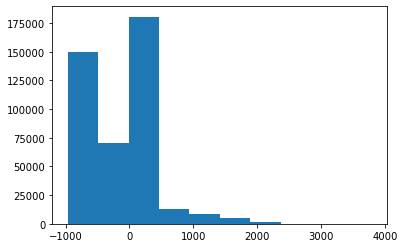

In [10]:
mc.predictions(input_folder,output_folder)

In [6]:
mc.__dict__

{'pix_x': 0,
 'pix_y': 0,
 'pix_z': 0,
 'scan': 0,
 'canal_mask': 0,
 'teeth_mask': 0,
 'panorama_view': 0,
 'panorama_view_mask': 0,
 'parasagittal_view': [],
 'frontal_view': 0,
 'sideMIP_left': 0,
 'sideMIP_right': 0,
 'minimum_distances': 0,
 'minimum_distance': 0,
 'axial_view': 0,
 'axial_perpendicular': 0,
 'parsagittal_radius': 50,
 'parsagittal_skips': 2,
 'parsagittal_starting': 30,
 'parsagittal_count': 10,
 'parsagittal_gr_skips': 40,
 'parasagittal_arch': 0,
 'parasagittal_windowed_scan': 0,
 'parasagittal_runtimes': 3,
 'panorama_arch': 0,
 'panorama_ss': 35,
 'panorama_length': 30,
 'panorama_cond': False,
 'panorama_skips': 20,
 'panorama_windowed_scan': 0,
 'uid': 0,
 'output_list': [],
 'classUID': [],
 'mimeType': [],
 'annotations': [],
 'recommendation_string': [],
 'gpu_id': 1}